In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.morphology
import os

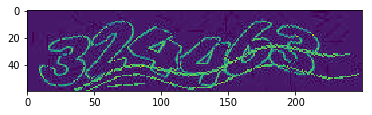

In [4]:
im = cv2.imread("images/full/324463.jpg")
a = np.asarray(im)
a = a[:,:,0]
a = a/255
a = 1-a
#a = a>0.1

plt.imshow(a)

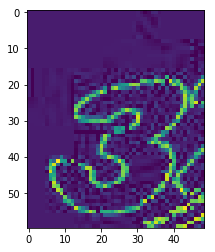

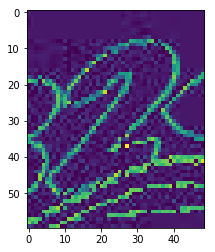

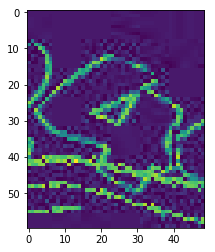

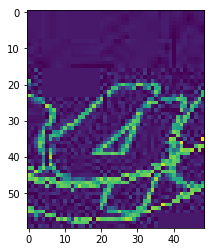

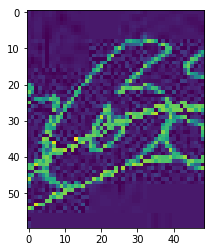

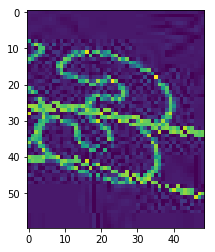

In [5]:
l = 10
r = 220

s = int((r-l)/6)

for i in range(6):
    plt.imshow(a[:, l + i*s-7: l + (i+1)*s + 7])
    plt.show()


In [ ]:
def encode(c):
    if(ord('0')<= ord(c) <= ord('9')): return ord(c) -ord('0');
    else: return ord(c) - ord('a') + 10
    
def decode(c):
    if(c<10): return str(c)[1]
    else: return chr(c-10 + ord('a'))

decode(11)

In [39]:
#new_shape = (35,40)
new_shape = 60,49

loc = 'images/full'
folder = os.listdir(loc)

X = []
y = []

for image in folder:
    labels = image[:-4]
    if len(labels)!=6: continue
        
    image = loc + '/' + image
    im = cv2.imread(image)
    a = np.asarray(im)
    a = a[:,:,0]
    a = a/255
    a = 1-a
    
    if a.shape[0]!=60: continue;
    
    l = 10
    r = 220
    s = int((r-l)/6)

    for i in range(6):
        img = np.array(a[:, l + i*s-7: l + (i+1)*s + 7])
        #res = np.array(cv2.resize(img, dsize=new_shape, interpolation=cv2.INTER_CUBIC))
        X.append(img)
        y.append(encode(labels[i])) 




In [40]:
X = np.array(X)
y = np.array(y)

In [9]:
X.shape


(2406, 60, 49)

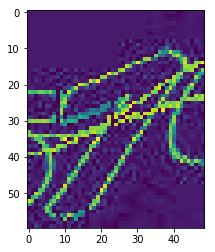

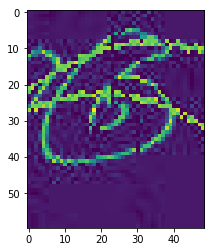

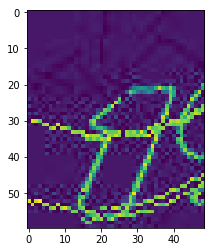

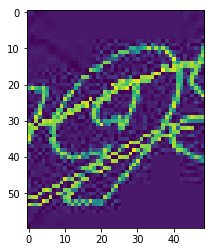

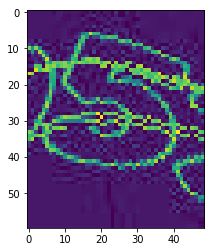

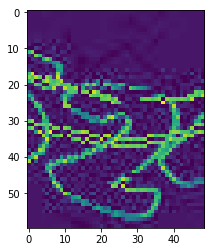

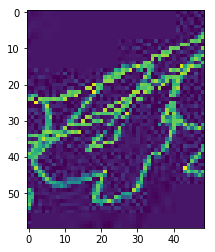

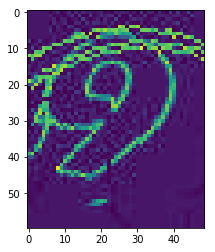

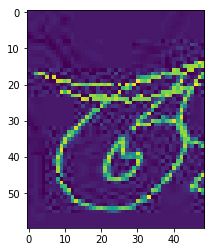

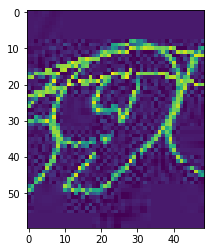

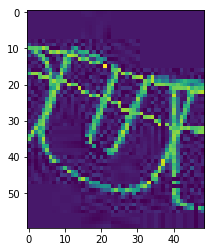

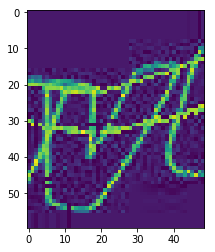

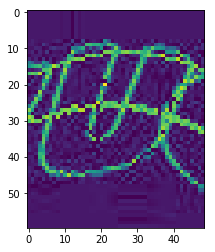

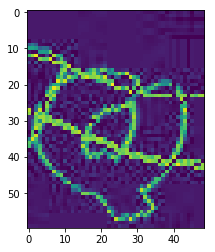

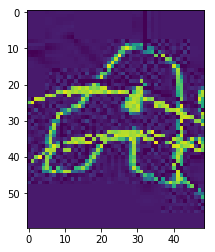

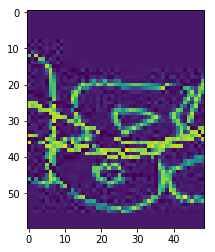

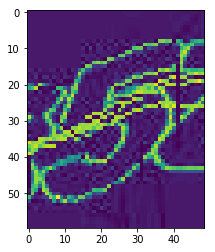

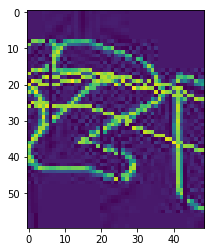

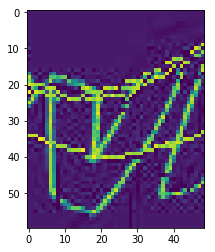

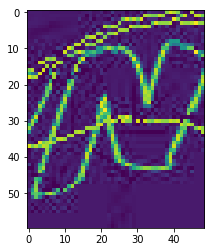

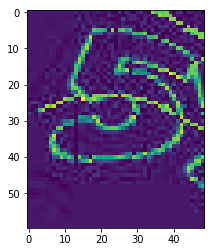

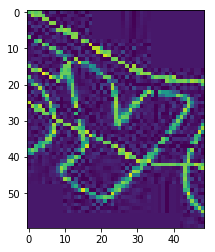

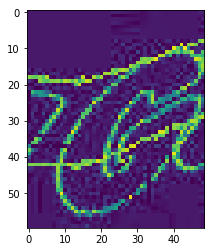

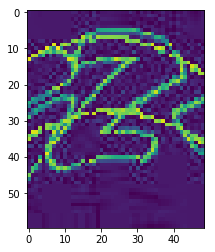

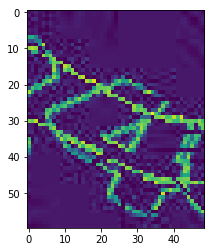

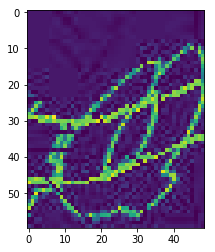

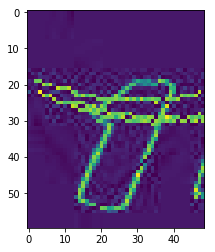

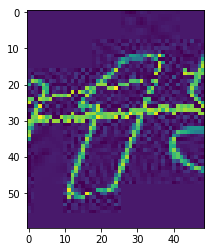

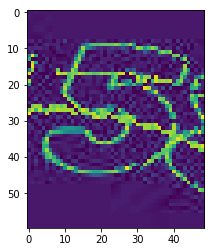

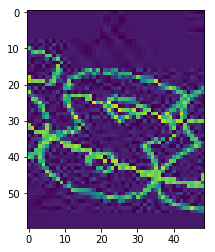

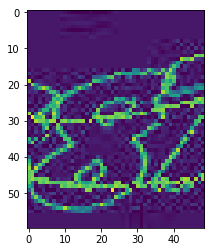

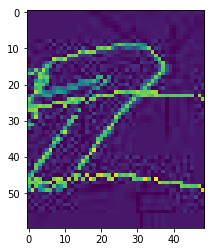

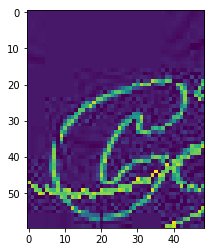

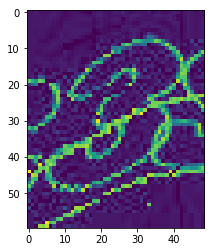

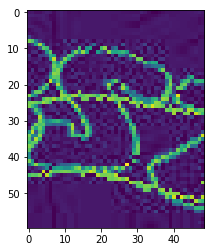

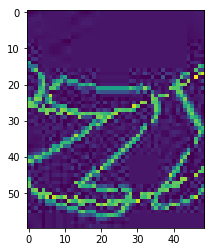

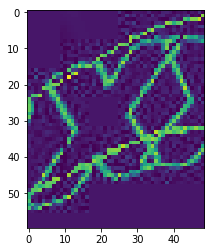

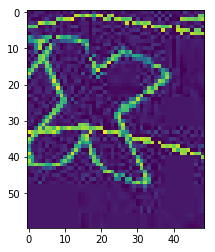

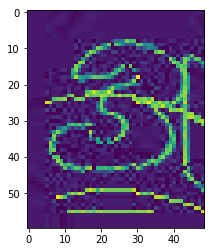

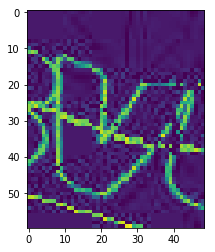

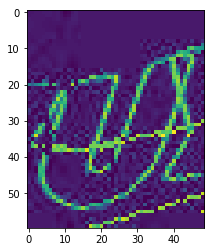

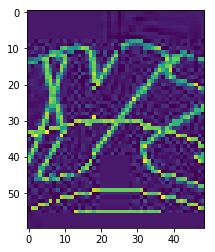

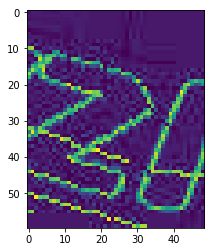

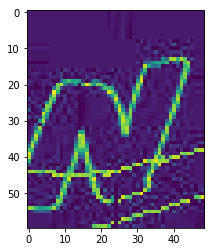

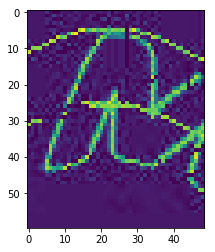

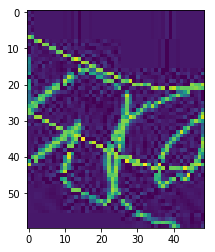

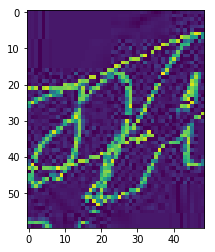

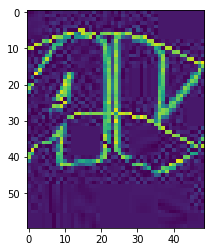

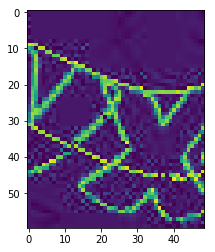

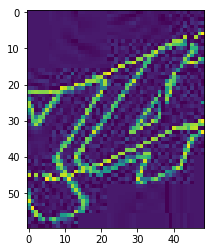

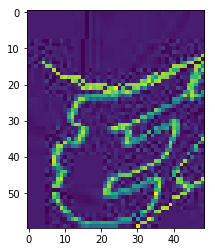

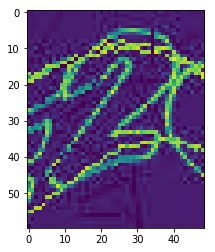

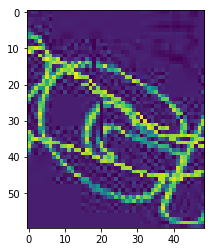

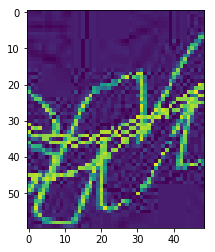

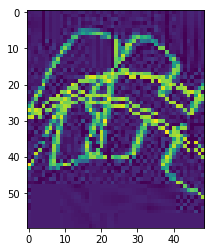

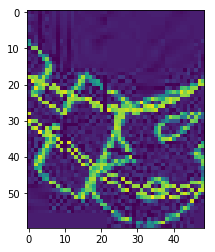

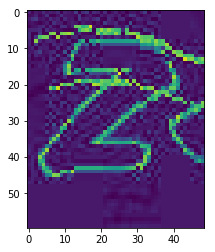

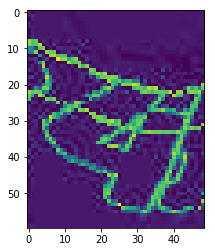

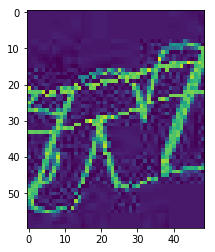

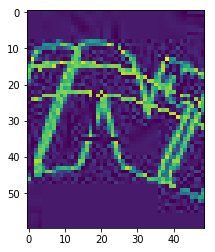

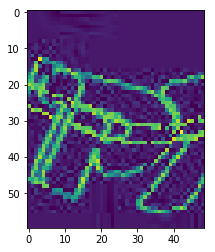

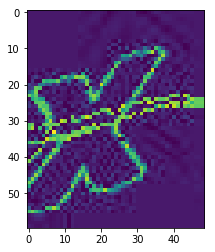

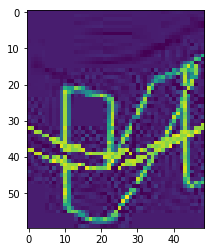

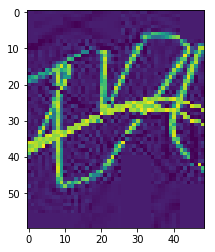

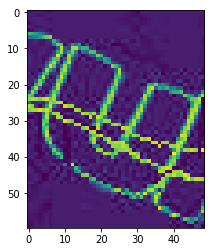

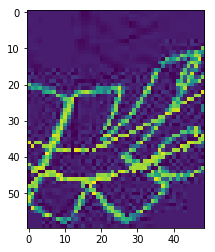

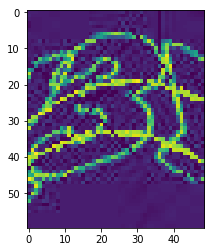

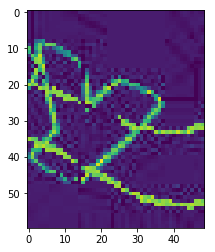

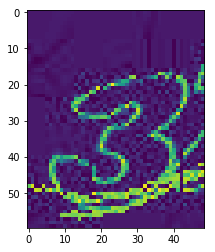

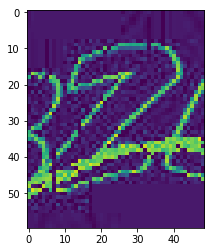

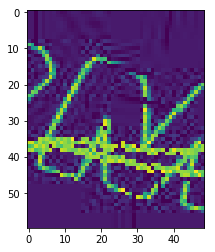

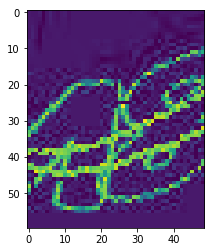

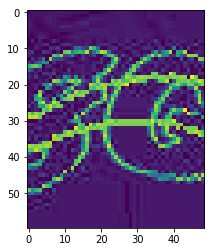

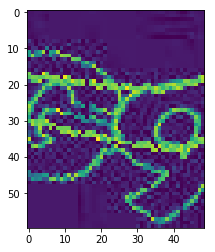

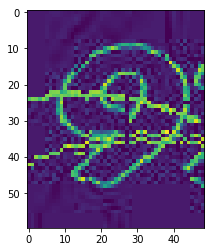

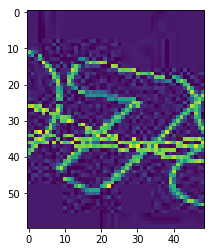

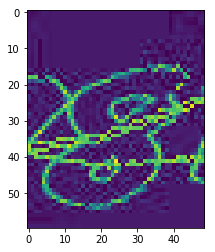

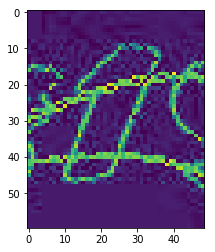

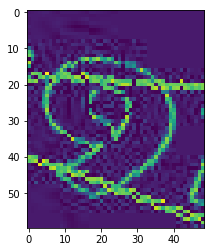

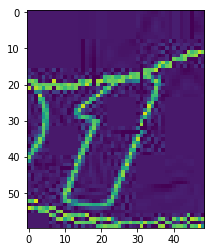

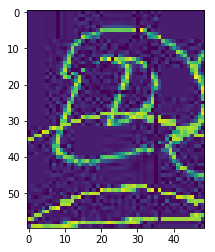

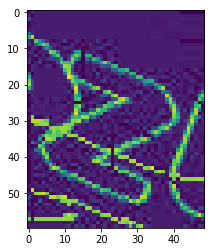

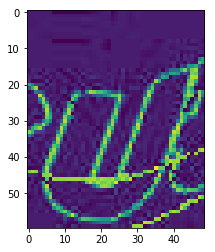

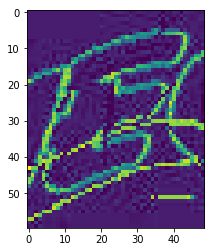

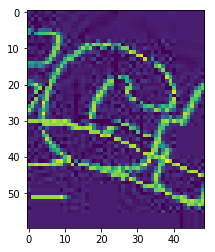

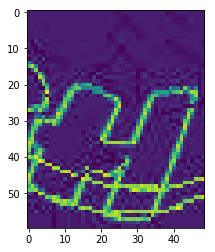

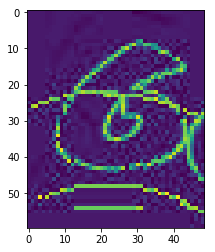

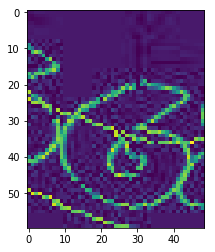

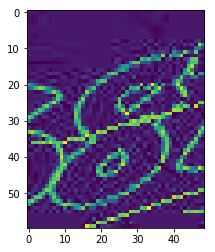

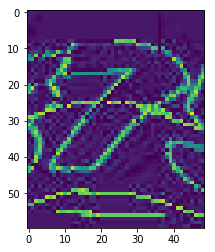

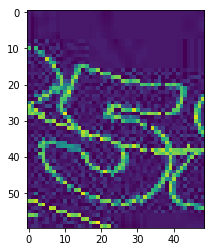

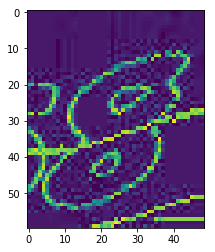

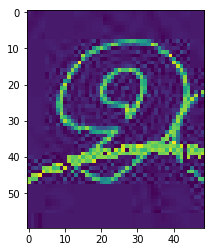

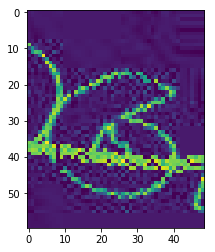

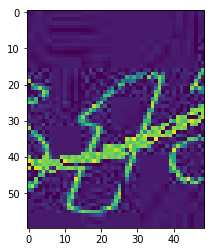

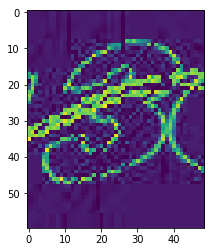

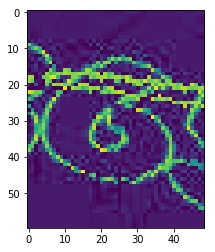

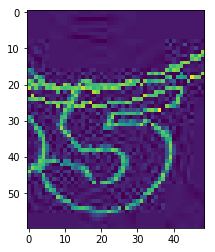

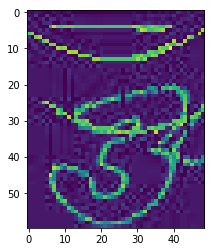

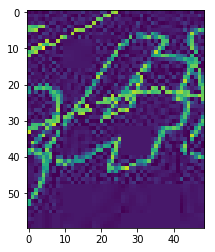

In [16]:
for i in range(700, 800):
    plt.imshow(X[i, :, :, 0])
    plt.show()

In [41]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



In [42]:
X = X.reshape(-1, 60,49,1)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=2)

In [18]:
X_train.shape

(2165, 60, 49, 1)

In [19]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu', input_shape = (60,49,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(36, activation = "softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 47, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 20, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 9, 64)         0         
__________

In [45]:
optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 30
batch_size = 4
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [43]:
from keras.models import load_model
model = load_model('captcha_model.h5')

In [46]:
final = model.fit(X_train, y_train, batch_size = batch_size, epochs = 20, validation_data = (X_test, y_test),callbacks=[learning_rate_reduction])
#results = model.predict(test)

Train on 2165 samples, validate on 241 samples
Epoch 1/20
2165/2165 [==============================] - 68s 31ms/step - loss: 0.2591 - acc: 0.9256 - val_loss: 0.3154 - val_acc: 0.9212
Epoch 2/20
 360/2165 [===>..........................] - ETA: 58s - loss: 0.1609 - acc: 0.9472

KeyboardInterrupt: 

In [47]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0.10,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
        
datagen.fit(X_train)

h = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 16),
                              epochs = 100, validation_data = (X_test , y_test),
                              steps_per_epoch=10,  # // batch_size
                              callbacks=[learning_rate_reduction]), 

Epoch 1/100
10/10 [==============================] - 6s 604ms/step - loss: 1.4069 - acc: 0.6937 - val_loss: 0.3246 - val_acc: 0.9212
Epoch 2/100
10/10 [==============================] - 7s 687ms/step - loss: 1.3805 - acc: 0.6625 - val_loss: 0.3287 - val_acc: 0.9253
Epoch 3/100
10/10 [==============================] - 6s 600ms/step - loss: 0.9909 - acc: 0.7250 - val_loss: 0.3585 - val_acc: 0.8963
Epoch 4/100
10/10 [==============================] - 6s 626ms/step - loss: 0.7412 - acc: 0.7875 - val_loss: 0.3019 - val_acc: 0.9212
Epoch 5/100
10/10 [==============================] - 6s 597ms/step - loss: 1.1166 - acc: 0.6813 - val_loss: 0.2885 - val_acc: 0.9253

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/100
10/10 [==============================] - 6s 601ms/step - loss: 0.9421 - acc: 0.7625 - val_loss: 0.2847 - val_acc: 0.9170
Epoch 7/100
10/10 [==============================] - 6s 624ms/step - loss: 0.9402 - acc: 0.7375 - val_loss: 0.2794 - val_

KeyboardInterrupt: 

array([23, 28,  5,  1, 14, 20,  4, 14,  6,  6, 35,  5,  2, 33, 17, 20, 26,
        7, 10, 14,  3,  9,  1,  7, 16, 12,  8,  5,  9,  2,  8,  6,  9,  5,
        2, 26, 17, 25, 33,  4,  6, 25, 22,  4,  8,  5,  5, 17,  8,  9,  6,
       26, 20,  5,  5,  7, 13, 12, 17,  9, 30, 31,  8,  9,  4, 20, 16, 33,
        4,  4,  5,  8,  1,  9,  4,  9,  3,  2,  9, 20,  5,  5,  5, 33,  3,
        2,  3,  4,  8, 31, 34,  6,  4,  3, 13,  5, 14,  5,  6,  1, 16, 31,
       28, 28,  4, 35, 34, 28,  8,  8, 33,  6,  8, 16, 35, 26, 35, 13,  3,
        5, 33,  4, 35,  4,  9,  1,  8, 31, 10,  3,  3,  9,  9,  2,  6,  4,
        4,  3,  3,  9,  5, 34, 23,  3,  9,  8,  3,  3, 17,  1,  9, 14,  3,
        2,  2, 33, 13,  3, 14, 33,  8,  6,  4,  3,  5,  4, 33,  4,  6,  8,
       33,  1,  3, 22,  7, 22, 25,  7, 35, 10,  7, 34, 26, 33, 26])

In [53]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
#classification_report(y_test, y_pred)


SyntaxError: unexpected EOF while parsing (<ipython-input-53-280cf6706156>, line 4)

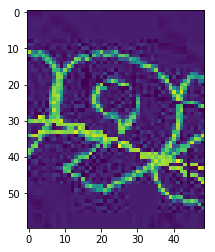

In [16]:
plt.imshow(img)

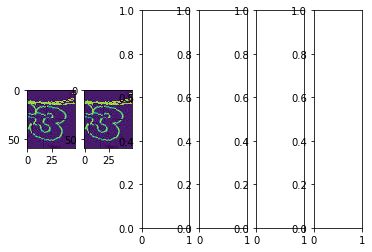

In [31]:
fig, ax = plt.subplots(1,6)
#ax[0, 0].plot(range(10), 'r') #row=0, col=0
ax[0].imshow(img)
ax[1].imshow(img)


In [36]:
a

array([[0.02745098, 0.08235294, 0.05098039, ..., 0.04313725, 0.04313725,
        0.04313725],
       [0.03137255, 0.        , 0.03921569, ..., 0.04313725, 0.04313725,
        0.04313725],
       [0.05098039, 0.14901961, 0.06666667, ..., 0.04313725, 0.04313725,
        0.04313725],
       ...,
       [0.03529412, 0.04705882, 0.03137255, ..., 0.04313725, 0.04313725,
        0.04313725],
       [0.04313725, 0.05098039, 0.03529412, ..., 0.04313725, 0.04313725,
        0.04313725],
       [0.04705882, 0.05490196, 0.03921569, ..., 0.04313725, 0.04313725,
        0.04313725]])

u2cxg3


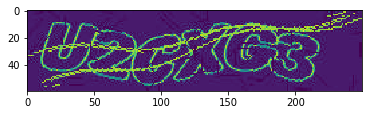

u
[2]
c
x
g
[3]


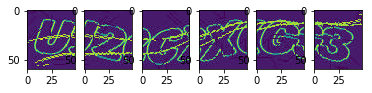

683799


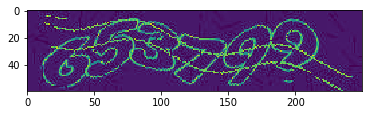

[6]
[5]
[3]
[7]
[9]
[9]


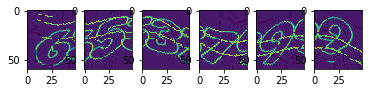

6sgppv


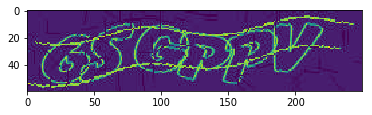

[6]
s
g
p
p
v


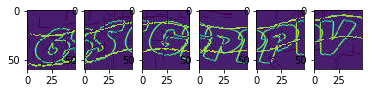

987469


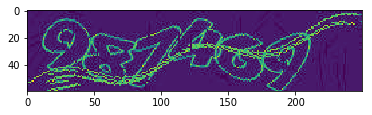

[9]
[8]
[7]
[4]
[6]
[9]


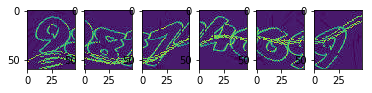

hadxqk


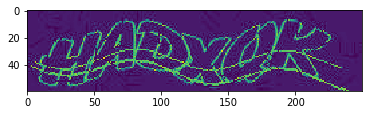

h
a
d
x
q
k


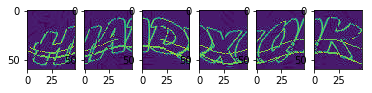

8c8g9g


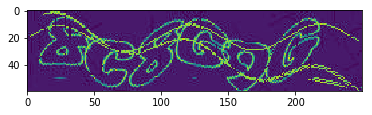

[8]
c
[8]
g
[9]
g


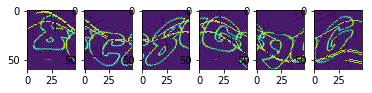

sqdkk9


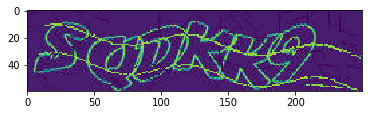

s
q
d
k
k
[9]


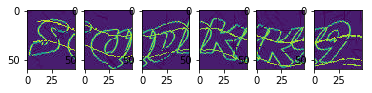

827185


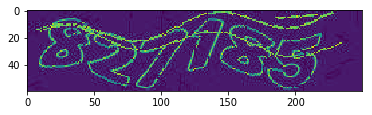

[8]
[2]
[7]
[1]
[8]
[5]


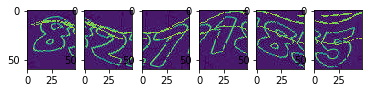

y62yz8


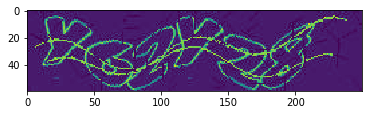

y
[6]
[2]
y
z
[8]


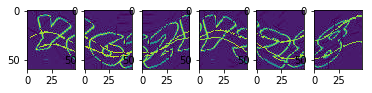

4vp3x4


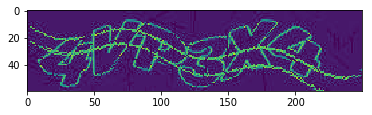

[4]
v
p
[3]
x
[4]


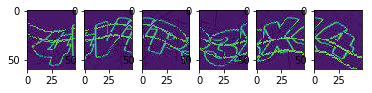

ae3k8z


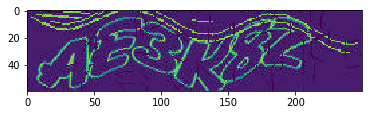

a
e
[3]
k
[8]
z


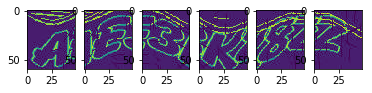

nqg9ag


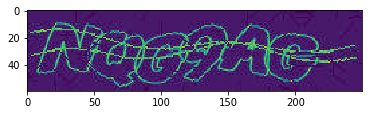

n
q
g
[9]
a
g


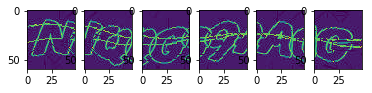

cvh2ze


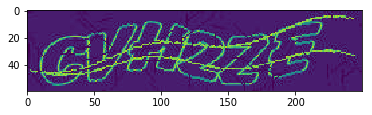

c
v
h
[2]
z
e


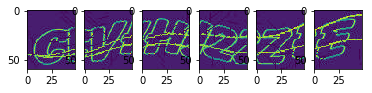

q4u2v6


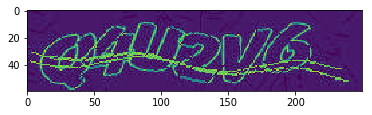

q
[4]
u
[2]
v
[6]


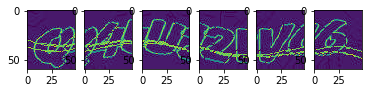

8gcaym


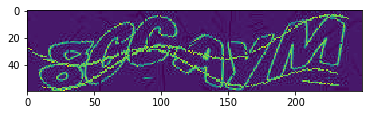

[8]
c
c
a
y
m


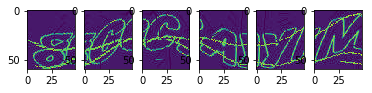

c4hvk2


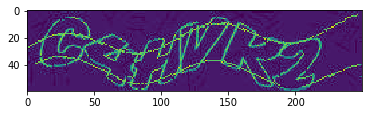

c
[4]
h
v
k
[2]


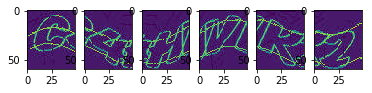

cs2xh3


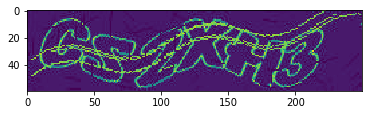

c
s
[2]
x
h
[3]


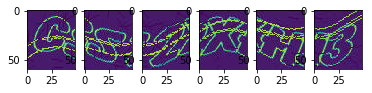

351777


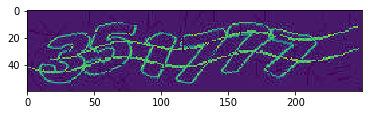

[3]
[5]
[1]
[7]
[7]
[7]


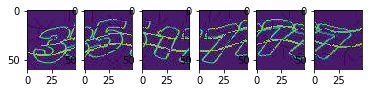

284823


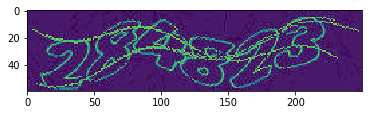

[2]
[8]
[4]
[8]
[2]
[3]


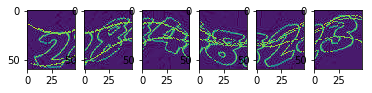

zv5vm5


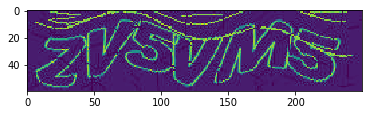

z
v
[5]
v
v
k


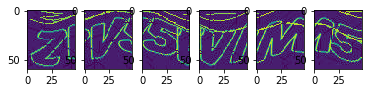

umdvm8


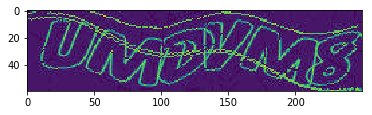

u
m
u
v
[4]
u


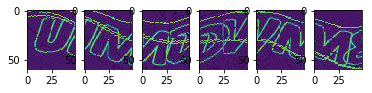

quuxuk


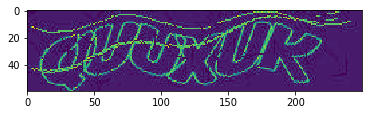

q
u
u
x
u
k


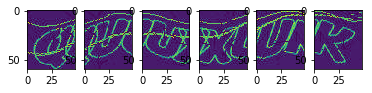

8xnse6


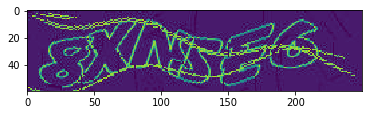

[8]
x
n
s
e
[6]


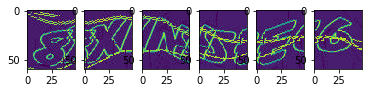

d3mh9n


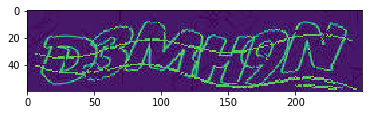

d
[3]
m
h
[9]
n


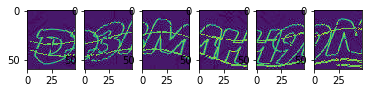

3g8kxy


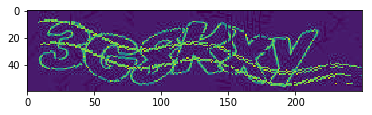

[3]
g
[8]
k
x
y


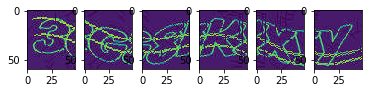

898992


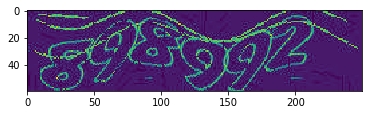

[8]
[9]
[8]
[9]
[9]
[2]


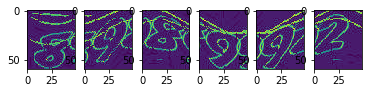

a8vs59


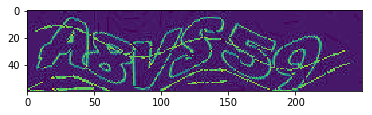

a
[8]
v
s
[5]
[9]


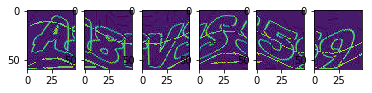

998238


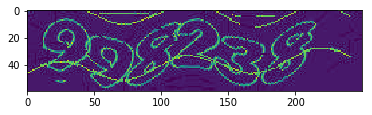

[9]
[9]
[8]
[2]
[3]
[8]


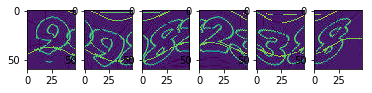

868849


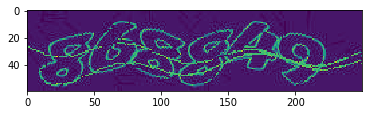

[8]
[6]
[8]
[8]
[4]
[9]


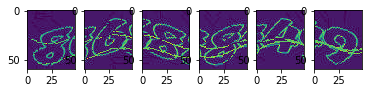

242899


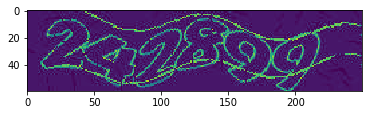

[2]
[4]
[2]
[8]
[9]
[9]


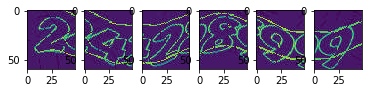

dxvh63


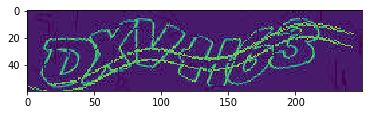

d
x
v
h
[6]
[3]


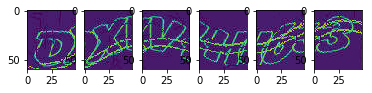

9926as


KeyboardInterrupt: 

In [52]:
new_shape = 60,49

loc = 'images/full'
folder = os.listdir(loc)

for image in folder:
    labels = image[:-4]
    if len(labels)!=6: continue

        
    image = loc + '/' + image
    im = cv2.imread(image)
    a = np.asarray(im)
    a = a[:,:,0]
    a = a/255
    a = 1-a
    
    if a.shape[0]!=60: continue;
    
    l = 10
    r = 220
    s = int((r-l)/6)
    
    print(labels)
    plt.imshow(a)
    plt.show()
    fig, ax = plt.subplots(1,6)
    captcha = ""
    for i in range(6):
        img = np.array(a[:, l + i*s-7: l + (i+1)*s + 7])    
        ax[i].imshow(img)
        captcha += decode(model.predict(img.reshape(1,60,49,1)).argmax(axis=1))
    print(captcha)
    plt.show()



In [48]:
model.save('captcha_model.h5')